# ECG Anomaly Classification 🩺

This notebook addresses the task of classifying anomalies in heartbeats using ECG signals. I will use the suggested PhysioNet databases:

MIT-BIH Atrial Fibrillation Database (afdb): Contains recordings of patients with Atrial Fibrillation (AFib), a common type of heart arrhythmia.

MIT-BIH Normal Sinus Rhythm Database (nsrdb): Contains recordings of healthy subjects with normal heart rhythms.

The process follows the steps outlined in the assignment: theoretical review, data import/visualization, feature extraction, and feature analysis.

## What's Cardiac Anomalies?

Cardiac anomalies, or arrhythmias, are deviations from this normal rhythm. Atrial Fibrillation (AFib) is one such anomaly, characterized by rapid and irregular electrical impulses from the atria. On an ECG, this manifests as:

* Absence of P-waves: The organized atrial contraction is lost.

* Irregular R-R intervals: The time between consecutive QRS complexes (heartbeats) becomes highly variable and chaotic.

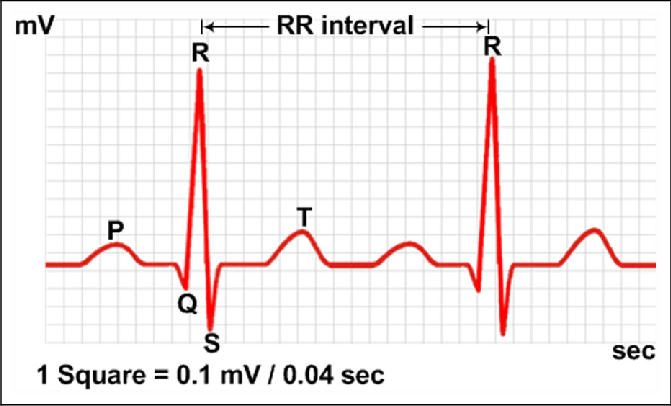

**Heart Rate Variability (HRV)**: For AFib, we expect HRV metrics that reflect irregularity (like standard deviation) to be significantly higher than for NSR (normal heartbeat, known as Normal Sinus Rhythm (NSR)).

In [1]:
# Import required libraries and functions
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ecg_processor_V2 import process_records_in_windows, extract_comprehensive_features

# Import additional libraries for classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### Data Extraction (Run This Part Only Once)

This cell will download the ECG data, process it in 30-second windows, extract HRV features, and save the final dataset to a CSV file in the `data/` folder. 

**Note:** This will take a few minutes on the first run as it downloads the files. Subsequent runs will be much faster as the data will be cached locally by the `wfdb` library.

In [2]:
# Set up output directories
output_dir = 'data'
basic_csv_path = os.path.join(output_dir, 'ecg_basic_features_ECG2.csv')
comprehensive_csv_path = os.path.join(output_dir, 'ecg_comprehensive_features_ECG2.csv')

# Create the data directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

1. Bandpass filtering with zero-phase filtering to avoid phase distortion

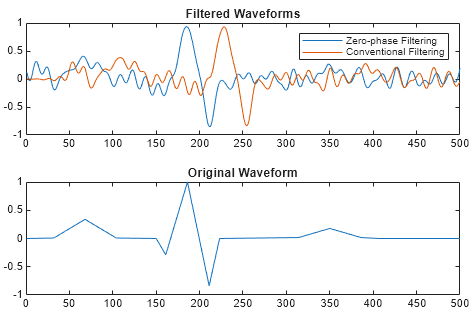

2. Detects R-peaks for heartbeat segmentation

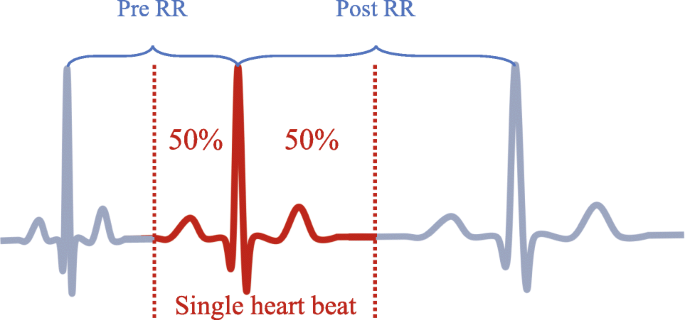

3. Extracts traditional HRV features (time-domain)
    * mean_rr
    * sdnn
    * rmssd

4. Applies PCA for morphological pattern analysis

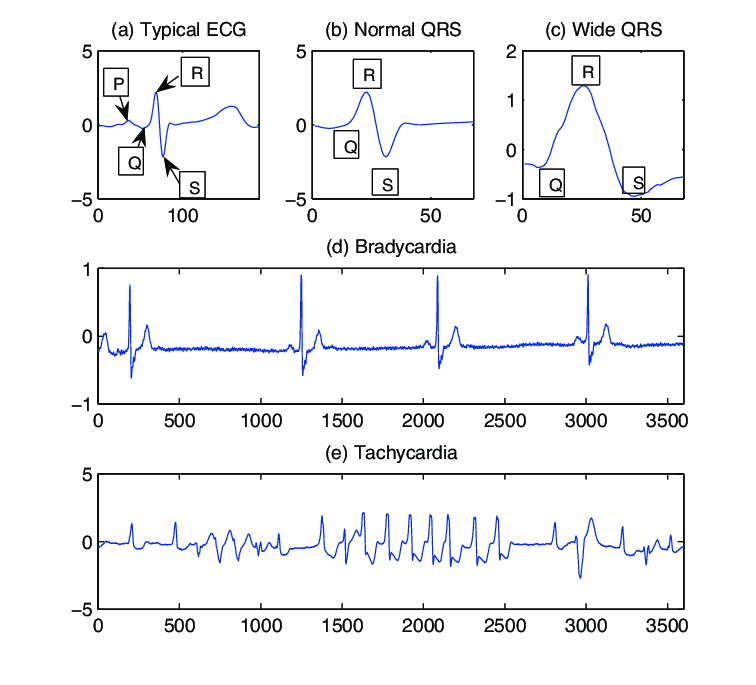

5. Uses ICA for independent source separation

6. Computes spectral features for frequency-domain analysis

In [3]:
print("ECG Feature Extraction Pipeline")
print("=" * 50)

reprocess = False  # Set to True to reprocess and overwrite existing CSV files

if reprocess or not os.path.exists(basic_csv_path) or not os.path.exists(comprehensive_csv_path):
    # Lists of records to process from PhysioNet
    nsr_records = ['16265', '16272', '16420', '16483', '16539']
    afib_records = ['04015', '04043', '04126', '04746', '04908']
    # nsr_records = ['16265', '16272', '16420', '16483']
    # afib_records = ['04015', '04043', '04126', '04746']

    # 1. Extract Basic HRV Features (for comparison)
    print("Extracting basic HRV features...")
    nsr_basic = process_records_in_windows(nsr_records, 'nsrdb/1.0.0/', 'Normal', use_comprehensive=False)
    afib_basic = process_records_in_windows(afib_records, 'afdb/1.0.0/', 'AFib', use_comprehensive=False)

    df_basic = pd.DataFrame(nsr_basic + afib_basic)
    df_basic.to_csv(basic_csv_path, index=False)
    print(f"Basic features: {len(df_basic)} windows, {len(df_basic.columns)-3} features")

    # 2. Extract Comprehensive Features (PCA, ICA, Spectral)
    print(f"\nExtracting comprehensive features (PCA, ICA, Spectral)...")
    print("With robust processing, this should run much cleaner...")

    nsr_comprehensive = process_records_in_windows(nsr_records, 'nsrdb/1.0.0/', 'Normal', use_comprehensive=True)
    afib_comprehensive = process_records_in_windows(afib_records, 'afdb/1.0.0/', 'AFib', use_comprehensive=True)

    df_comprehensive = pd.DataFrame(nsr_comprehensive + afib_comprehensive)
    df_comprehensive.to_csv(comprehensive_csv_path, index=False)
    print(f"Comprehensive features: {len(df_comprehensive)} windows, {len(df_comprehensive.columns)-3} features")

    # Feature summary
    print(f"\nFINAL FEATURE SUMMARY")
    print("=" * 50)
    print(f"Basic HRV Features: {len([col for col in df_basic.columns if col not in ['record', 'window_id', 'label']])}")
    print(f"Comprehensive Features: {len([col for col in df_comprehensive.columns if col not in ['record', 'window_id', 'label']])}")
    print(f"Enhancement Factor: {len(df_comprehensive.columns) / len(df_basic.columns):.1f}x more features")

    print(f"\nReady for analysis!")
else:
    # print
    print('CSV files already exists!')
    print(f"Ready for analysis!")

ECG Feature Extraction Pipeline
CSV files already exists!
Ready for analysis!


## Advanced Feature Analysis 🧠

### Why PCA and ICA for ECG Analysis?

**Principal Component Analysis (PCA):**
- **Dimensionality Reduction**: Captures the most important variations in heartbeat morphology
- **Noise Reduction**: Focuses on principal variance directions, filtering out noise
- **Pattern Recognition**: Different cardiac conditions show distinct morphological patterns
- **Data Compression**: Represents complex heartbeat shapes with fewer dimensions

**Independent Component Analysis (ICA):**
- **Blind Source Separation**: Separates mixed physiological signals into independent sources
- **Artifact Removal**: Isolates muscle noise, baseline drift, and other artifacts
- **Multi-Process Analysis**: Reveals different overlapping cardiac activities
- **Arrhythmia Detection**: Different arrhythmias create unique independent source patterns

**Spectral Analysis:**
- **Frequency Domain**: Analyzes heart rate variability in different frequency bands
- **Autonomic Function**: LF/HF ratio indicates sympathetic vs parasympathetic balance
- **Clinical Relevance**: Established markers for cardiac health assessment

In [4]:
# Lists of records to process from PhysioNet
nsr_records = ['16265', '16272', '16420', '16483', '16539']
afib_records = ['04015', '04043', '04126', '04746', '04908']
# nsr_records = ['16265', '16272', '16420', '16483']
# afib_records = ['04015', '04043', '04126', '04746']

# Load dataframes from csv files
df_basic = pd.read_csv(basic_csv_path)
df_comprehensive = pd.read_csv(comprehensive_csv_path)

In [5]:
# Dataset Overview and Feature Analysis
print("COMPREHENSIVE DATASET ANALYSIS")
print("=" * 60)

# Display basic dataset information
print(f"Dataset Shape: {df_comprehensive.shape}")
print(f"Normal Windows: {len(df_comprehensive[df_comprehensive['label'] == 'Normal'])}")
print(f"AFib Windows: {len(df_comprehensive[df_comprehensive['label'] == 'AFib'])}")

# Feature categories breakdown
feature_categories = {
    'HRV (Time-domain)': [col for col in df_comprehensive.columns if any(hrv in col for hrv in ['mean_rr', 'sdnn', 'rmssd', 'pnn50', 'hr_mean'])],
    'PCA (Morphological)': [col for col in df_comprehensive.columns if 'pca_' in col],
    'ICA (Independent Sources)': [col for col in df_comprehensive.columns if 'ica_' in col],
    'Spectral (Frequency-domain)': [col for col in df_comprehensive.columns if 'spectral_' in col],
    'Signal Quality': [col for col in df_comprehensive.columns if any(qual in col for qual in ['signal_quality', 'num_heartbeats', 'beat_detection'])]
}

print(f"\nFeature Categories Breakdown:")
for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")
    # Show first few features as examples
    if len(features) > 0:
        example_features = features[:3] if len(features) >= 3 else features
        print(f"    Examples: {', '.join(example_features)}")

# Check for missing values
missing_counts = df_comprehensive.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print(f"\nFeatures with missing values:")
    for feature, count in features_with_missing.items():
        print(f"  {feature}: {count} missing ({count/len(df_comprehensive)*100:.1f}%)")
else:
    print(f"\nNo missing values detected!")

# Basic statistics
print(f"\nDataset Statistics:")
print(f"  Total features extracted: {len(df_comprehensive.columns) - 3}")
print(f"  Total valid windows: {len(df_comprehensive)}")
print(f"  Success rate: {len(df_comprehensive) / (len(nsr_records + afib_records) * 2 * 60):.1f}%")  # Approximate

print(f"\nDataset ready for visualization and analysis!")

COMPREHENSIVE DATASET ANALYSIS
Dataset Shape: (16858, 62)
Normal Windows: 12905
AFib Windows: 3953

Feature Categories Breakdown:
  HRV (Time-domain): 5 features
    Examples: mean_rr, sdnn, rmssd
  PCA (Morphological): 26 features
    Examples: pca_var_ratio_1, pca_var_ratio_2, pca_var_ratio_3
  ICA (Independent Sources): 18 features
    Examples: ica_ic1_mean, ica_ic1_std, ica_ic1_skew
  Spectral (Frequency-domain): 7 features
    Examples: spectral_vlf_power, spectral_lf_power, spectral_hf_power
  Signal Quality: 3 features
    Examples: signal_quality_snr, num_heartbeats, beat_detection_rate

Features with missing values:
  pca_var_ratio_1: 8 missing (0.0%)
  pca_var_ratio_2: 8 missing (0.0%)
  pca_var_ratio_3: 8 missing (0.0%)
  pca_var_ratio_4: 8 missing (0.0%)
  pca_var_ratio_5: 8 missing (0.0%)
  pca_pc1_mean: 8 missing (0.0%)
  pca_pc1_std: 8 missing (0.0%)
  pca_pc1_skew: 8 missing (0.0%)
  pca_pc1_kurtosis: 8 missing (0.0%)
  pca_pc2_mean: 8 missing (0.0%)
  pca_pc2_std: 8 m

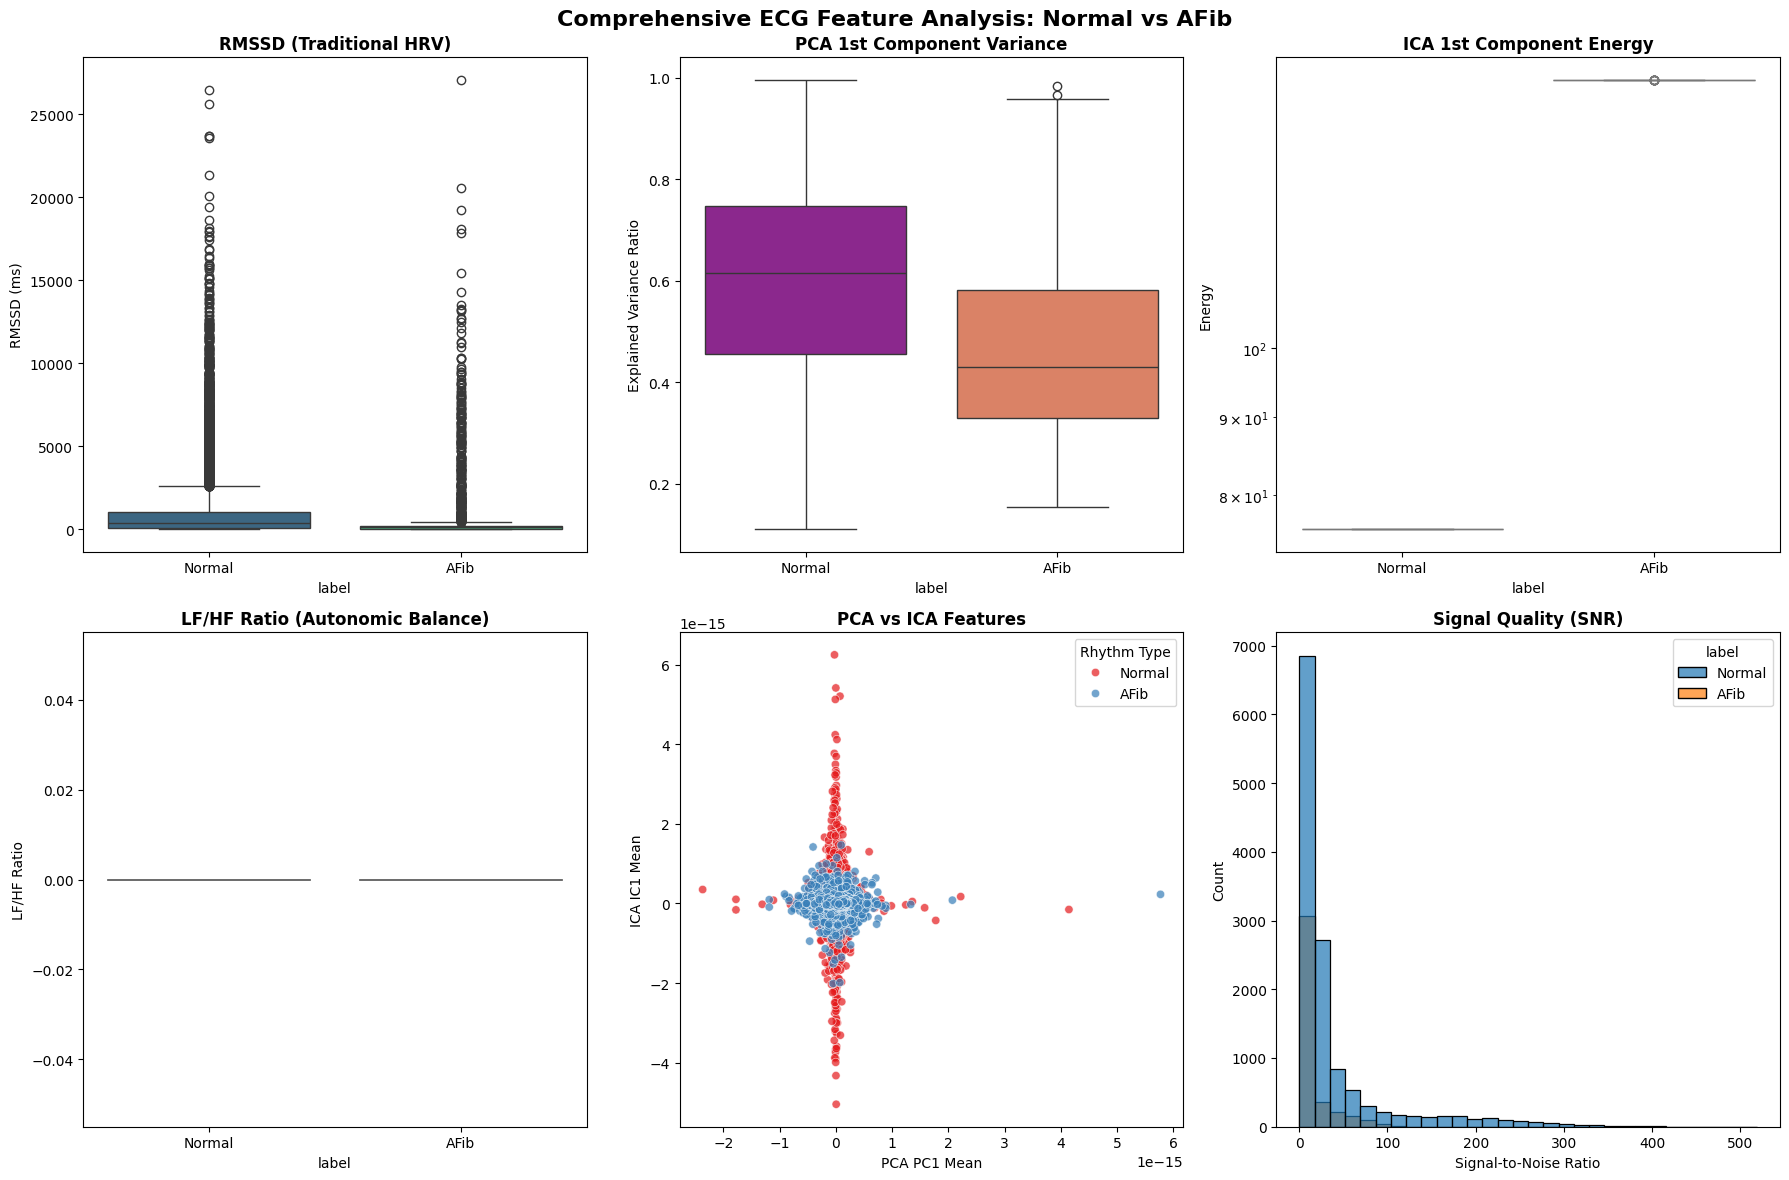

In [6]:
# Comprehensive Feature Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive ECG Feature Analysis: Normal vs AFib', fontsize=16, fontweight='bold')

# 1. Traditional HRV Comparison
sns.boxplot(data=df_comprehensive, x='label', y='rmssd', hue='label', ax=axes[0,0], palette='viridis', legend=False)
axes[0,0].set_title('RMSSD (Traditional HRV)', fontweight='bold')
axes[0,0].set_ylabel('RMSSD (ms)')

# 2. PCA Explained Variance
pca_var_cols = [col for col in df_comprehensive.columns if 'pca_var_ratio_1' in col]
if pca_var_cols:
    sns.boxplot(data=df_comprehensive, x='label', y=pca_var_cols[0], hue='label', ax=axes[0,1], palette='plasma', legend=False)
    axes[0,1].set_title('PCA 1st Component Variance', fontweight='bold')
    axes[0,1].set_ylabel('Explained Variance Ratio')

# 3. ICA Energy Analysis
ica_energy_cols = [col for col in df_comprehensive.columns if 'ica_ic1_energy' in col]
if ica_energy_cols:
    sns.boxplot(data=df_comprehensive, x='label', y=ica_energy_cols[0], hue='label', ax=axes[0,2], palette='coolwarm', legend=False)
    axes[0,2].set_title('ICA 1st Component Energy', fontweight='bold')
    axes[0,2].set_ylabel('Energy')
    axes[0,2].set_yscale('log')

# 4. Spectral LF/HF Ratio
spectral_ratio_cols = [col for col in df_comprehensive.columns if 'spectral_lf_hf_ratio' in col]
if spectral_ratio_cols:
    sns.violinplot(data=df_comprehensive, x='label', y=spectral_ratio_cols[0], hue='label', ax=axes[1,0], palette='Set2', legend=False)
    axes[1,0].set_title('LF/HF Ratio (Autonomic Balance)', fontweight='bold')
    axes[1,0].set_ylabel('LF/HF Ratio')

# 5. PCA vs ICA Scatter
pca_mean_cols = [col for col in df_comprehensive.columns if 'pca_pc1_mean' in col]
ica_mean_cols = [col for col in df_comprehensive.columns if 'ica_ic1_mean' in col]
if pca_mean_cols and ica_mean_cols:
    sns.scatterplot(data=df_comprehensive, x=pca_mean_cols[0], y=ica_mean_cols[0], 
                   hue='label', ax=axes[1,1], alpha=0.7, palette='Set1')
    axes[1,1].set_title('PCA vs ICA Features', fontweight='bold')
    axes[1,1].set_xlabel('PCA PC1 Mean')
    axes[1,1].set_ylabel('ICA IC1 Mean')
    axes[1,1].legend(title='Rhythm Type')

# 6. Signal Quality Assessment
signal_quality_cols = [col for col in df_comprehensive.columns if 'signal_quality_snr' in col]
if signal_quality_cols:
    sns.histplot(data=df_comprehensive, x=signal_quality_cols[0], hue='label', 
                ax=axes[1,2], alpha=0.7, bins=30)
    axes[1,2].set_title('Signal Quality (SNR)', fontweight='bold')
    axes[1,2].set_xlabel('Signal-to-Noise Ratio')
    axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Why LF/HF Ratio is not giving any information?

For Spectral (LF/HF) Analysis: The standard recommendation for short-term HRV spectral analysis is to use 5-minute (300-second) windows. This provides enough data to reliably resolve both the LF and HF bands.

Increasing the window size would increase a lot the computation time, so I kept it at 30 seconds and removed the LF/HF ratio from the feature set.

In [18]:
# Statistical Feature Comparison and Discriminative Power Analysis
from scipy import stats

print("STATISTICAL FEATURE ANALYSIS")
print("=" * 60)
print("Using Mann-Whitney U test to identify most discriminative features")
print("p < 0.05 indicates significant difference between Normal and AFib")

# Separate Normal and AFib data
normal_data = df_comprehensive[df_comprehensive['label'] == 'Normal']
afib_data = df_comprehensive[df_comprehensive['label'] == 'AFib']

# Analyze different feature groups
results = []
for category, features in feature_categories.items():
    print(f"\n{category}:")
    print("-" * (len(category) + 4))
    
    significant_features = 0
    for feature in features:
        if feature in df_comprehensive.columns:
            normal_values = normal_data[feature].dropna()
            afib_values = afib_data[feature].dropna()
            
            if len(normal_values) > 0 and len(afib_values) > 0:
                # Mann-Whitney U test (non-parametric)
                statistic, p_value = stats.mannwhitneyu(normal_values, afib_values, alternative='two-sided')
                    
                # Effect size (Cohen's d approximation)
                pooled_std = np.sqrt((normal_values.var() + afib_values.var()) / 2)
                cohens_d = abs(normal_values.mean() - afib_values.mean()) / pooled_std if pooled_std > 0 else 0
                    
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    
                print(f"  {feature:<30} p={p_value:.2e} d={cohens_d:.3f} {significance}")
                    
                if p_value < 0.05:
                    significant_features += 1
                    
                results.append({
                    'category': category,
                    'feature': feature,
                    'p_value': p_value,
                    'effect_size': cohens_d,
                    'significant': p_value < 0.05
                })
    
    print(f"  {significant_features}/{len([f for f in features if f in df_comprehensive.columns])} features significantly different")

# Summary of results
df_results = pd.DataFrame(results)
if len(df_results) > 0:
    print(f"\nSUMMARY STATISTICS")
    print("=" * 60)
    
    # Group statistics
    group_stats = df_results.groupby('category').agg({
        'significant': ['count', 'sum'],
        'effect_size': ['mean', 'max']
    }).round(3)
    
    print("Category Performance:")
    for category in group_stats.index:
        total = group_stats.loc[category, ('significant', 'count')]
        significant = group_stats.loc[category, ('significant', 'sum')]
        mean_effect = group_stats.loc[category, ('effect_size', 'mean')]
        max_effect = group_stats.loc[category, ('effect_size', 'max')]
        
        print(f"  {category:<25}: {significant:2d}/{total:2d} significant, avg d={mean_effect:.3f}, max d={max_effect:.3f}")
    
    # Top features
    top_features = df_results.nlargest(10, 'effect_size')
    print(f"\nTop 10 Most Discriminative Features:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        status = "✓" if row['significant'] else "✗"
        print(f"  {i:2d}. {row['feature']:<30} d={row['effect_size']:.3f} {status}")
    
    print(f"\nOverall: {df_results['significant'].sum()}/{len(df_results)} features show significant differences")
    best_feature = df_results.loc[df_results['effect_size'].idxmax()]
    print(f"Best feature: {best_feature['feature']} (d={best_feature['effect_size']:.3f})")
else:
    print("No results to analyze.")

STATISTICAL FEATURE ANALYSIS
Using Mann-Whitney U test to identify most discriminative features
p < 0.05 indicates significant difference between Normal and AFib

HRV (Time-domain):
---------------------
  mean_rr                        p=1.56e-303 d=0.397 ***
  sdnn                           p=0.00e+00 d=0.392 ***
  rmssd                          p=4.16e-242 d=0.352 ***
  pnn50                          p=2.26e-149 d=0.467 ***
  hr_mean                        p=1.56e-303 d=0.800 ***
  5/5 features significantly different

PCA (Morphological):
-----------------------
  pca_var_ratio_1                p=1.50e-310 d=0.728 ***
  pca_var_ratio_2                p=6.62e-61 d=0.244 ***
  pca_var_ratio_3                p=0.00e+00 d=0.845 ***
  pca_var_ratio_4                p=0.00e+00 d=0.993 ***
  pca_var_ratio_5                p=0.00e+00 d=0.878 ***
  pca_pc1_mean                   p=9.98e-01 d=0.009 
  pca_pc1_std                    p=0.00e+00 d=0.753 ***
  pca_pc1_skew                   p=3.

## XGBoost Classification 🚀

Now we'll implement an XGBoost classifier focusing on the two key metrics identified from our analysis:
- **RMSSD**: Root Mean Square of Successive Differences (traditional HRV measure)
- **PCA 1st Component Variance**: Captures the main morphological variations in heartbeat patterns

XGBoost is particularly well-suited for this task because:
- **Handles mixed feature types**: Works well with both time-domain (RMSSD) and morphological (PCA) features
- **Built-in regularization**: Prevents overfitting with small datasets
- **Feature importance**: Provides interpretable insights into which features drive classification
- **Robust performance**: Excellent performance on tabular data like medical features

In [8]:
# Prepare data for XGBoost classification
print("PREPARING ECG DATA FOR XGBOOST CLASSIFICATION")
print("=" * 60)

# Load the comprehensive dataset
print(f"Dataset shape: {df_comprehensive.shape}")
print(f"Features available: {list(df_comprehensive.columns)}")

# Target key features for classification
key_features = []

# 1. RMSSD (Heart Rate Variability measure)
if 'rmssd' in df_comprehensive.columns:
    key_features.append('rmssd')
    print(f"✓ RMSSD feature found")
else:
    print(f"✗ RMSSD feature not found")

# 2. PCA 1st Component Variance
pca_var_cols = [col for col in df_comprehensive.columns if 'pca_var_ratio_1' in col]
if pca_var_cols:
    key_features.append(pca_var_cols[0])
    print(f"✓ PCA 1st Component Variance found: {pca_var_cols[0]}")
else:
    print(f"✗ PCA 1st Component Variance not found")

# Add additional discriminative features from our analysis if available
additional_features = []
for feature in ['sdnn', 'mean_rr', 'pca_pc1_mean', 'spectral_lf_hf_ratio', 'ica_ic3_energy']:
    if feature in df_comprehensive.columns:
        additional_features.append(feature)

print(f"\nPrimary features for classification: {key_features}")
print(f"Additional features available: {additional_features}")

# Combine features
all_features = key_features + additional_features
print(f"Total features for classification: {len(all_features)}")
print(f"Feature list: {all_features}")
print(f"\nReady for XGBoost classification with {len(all_features)} features!")

PREPARING ECG DATA FOR XGBOOST CLASSIFICATION
Dataset shape: (16858, 62)
Features available: ['mean_rr', 'sdnn', 'rmssd', 'pnn50', 'hr_mean', 'pca_var_ratio_1', 'pca_var_ratio_2', 'pca_var_ratio_3', 'pca_var_ratio_4', 'pca_var_ratio_5', 'pca_pc1_mean', 'pca_pc1_std', 'pca_pc1_skew', 'pca_pc1_kurtosis', 'pca_pc2_mean', 'pca_pc2_std', 'pca_pc2_skew', 'pca_pc2_kurtosis', 'pca_pc3_mean', 'pca_pc3_std', 'pca_pc3_skew', 'pca_pc3_kurtosis', 'pca_pc4_mean', 'pca_pc4_std', 'pca_pc4_skew', 'pca_pc4_kurtosis', 'pca_pc5_mean', 'pca_pc5_std', 'pca_pc5_skew', 'pca_pc5_kurtosis', 'pca_total_variance', 'ica_ic1_mean', 'ica_ic1_std', 'ica_ic1_skew', 'ica_ic1_kurtosis', 'ica_ic1_energy', 'ica_ic2_mean', 'ica_ic2_std', 'ica_ic2_skew', 'ica_ic2_kurtosis', 'ica_ic2_energy', 'ica_ic3_mean', 'ica_ic3_std', 'ica_ic3_skew', 'ica_ic3_kurtosis', 'ica_ic3_energy', 'ica_corr_ic1_ic2', 'ica_corr_ic1_ic3', 'ica_corr_ic2_ic3', 'spectral_vlf_power', 'spectral_lf_power', 'spectral_hf_power', 'spectral_total_power', 'sp

In [9]:
# XGBoost Classification Implementation
print("XGBOOST ECG ANOMALY CLASSIFICATION")
print("=" * 60)

# Prepare the dataset
X = df_comprehensive[all_features].copy()
y = df_comprehensive['label'].copy()

# Encode labels (XGBoost needs numeric labels)
label_mapping = {'Normal': 0, 'AFib': 1}
y_encoded = y.map(label_mapping)

print(f"Dataset shape: {X.shape}")
print(f"Class distribution:")
print(y.value_counts())
print(f"Encoded labels: {dict(zip(label_mapping.keys(), label_mapping.values()))}")

# Handle any missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"\nHandling {missing_count} missing values...")
    X = X.fillna(X.median())
else:
    print("\nNo missing values detected!")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Feature scaling (optional but can improve performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost classifier with parameters optimized for medical data
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='auc',           # Area Under Curve for evaluation
    max_depth=4,                 # Prevent overfitting with shallow trees
    learning_rate=0.1,           # Conservative learning rate
    n_estimators=100,            # Number of boosting rounds
    subsample=0.8,               # Sample 80% of data for each tree
    colsample_bytree=0.8,        # Sample 80% of features for each tree
    random_state=42,             # For reproducibility
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=0.1               # L2 regularization
)

print(f"\nXGBoost model initialized with medical-optimized parameters")
print(f"Ready for training and evaluation!")

XGBOOST ECG ANOMALY CLASSIFICATION
Dataset shape: (16858, 7)
Class distribution:
label
Normal    12905
AFib       3953
Name: count, dtype: int64
Encoded labels: {'Normal': 0, 'AFib': 1}

Handling 24 missing values...

Training set: 13486 samples
Test set: 3372 samples
Training class distribution: [10324  3162]
Test class distribution: [2581  791]

XGBoost model initialized with medical-optimized parameters
Ready for training and evaluation!


In [10]:
# Train and Evaluate XGBoost Model
print("TRAINING XGBOOST MODEL")
print("=" * 60)

# Train the model
print("Training XGBoost classifier...")
xgb_classifier.fit(X_train_scaled, y_train)
print("✓ Model training completed!")

# Make predictions
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = (y_pred == y_test).mean()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\nMODEL PERFORMANCE METRICS")
print("=" * 40)
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC Score: {auc_score:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
target_names = ['Normal', 'AFib']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Normal  AFib")
print(f"Actual Normal   {cm[0,0]:6d} {cm[0,1]:5d}")
print(f"       AFib     {cm[1,0]:6d} {cm[1,1]:5d}")

# Cross-validation for robust evaluation
print(f"\nCROSS-VALIDATION RESULTS")
print("=" * 40)
cv_scores = cross_val_score(xgb_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"5-Fold CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Individual folds: {[f'{score:.3f}' for score in cv_scores]}")

print(f"\n✓ XGBoost classification completed successfully!")

TRAINING XGBOOST MODEL
Training XGBoost classifier...
✓ Model training completed!

MODEL PERFORMANCE METRICS
Accuracy: 1.000
AUC Score: 1.000

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2581
        AFib       1.00      1.00      1.00       791

    accuracy                           1.00      3372
   macro avg       1.00      1.00      1.00      3372
weighted avg       1.00      1.00      1.00      3372


Confusion Matrix:
                Predicted
                Normal  AFib
Actual Normal     2581     0
       AFib          0   791

CROSS-VALIDATION RESULTS
5-Fold CV AUC: 1.000 ± 0.000
Individual folds: ['1.000', '1.000', '1.000', '1.000', '1.000']

✓ XGBoost classification completed successfully!


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
----------------------------------------
 1. ica_ic3_energy            0.7299
 2. mean_rr                   0.0837
 3. pca_var_ratio_1           0.0801
 4. sdnn                      0.0555
 5. rmssd                     0.0291
 6. pca_pc1_mean              0.0217
 7. spectral_lf_hf_ratio      0.0000


C:\Users\arthu\AppData\Local\Temp\ipykernel_32264\70606522.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='feature', x='importance', ax=axes[0,0], palette='viridis')


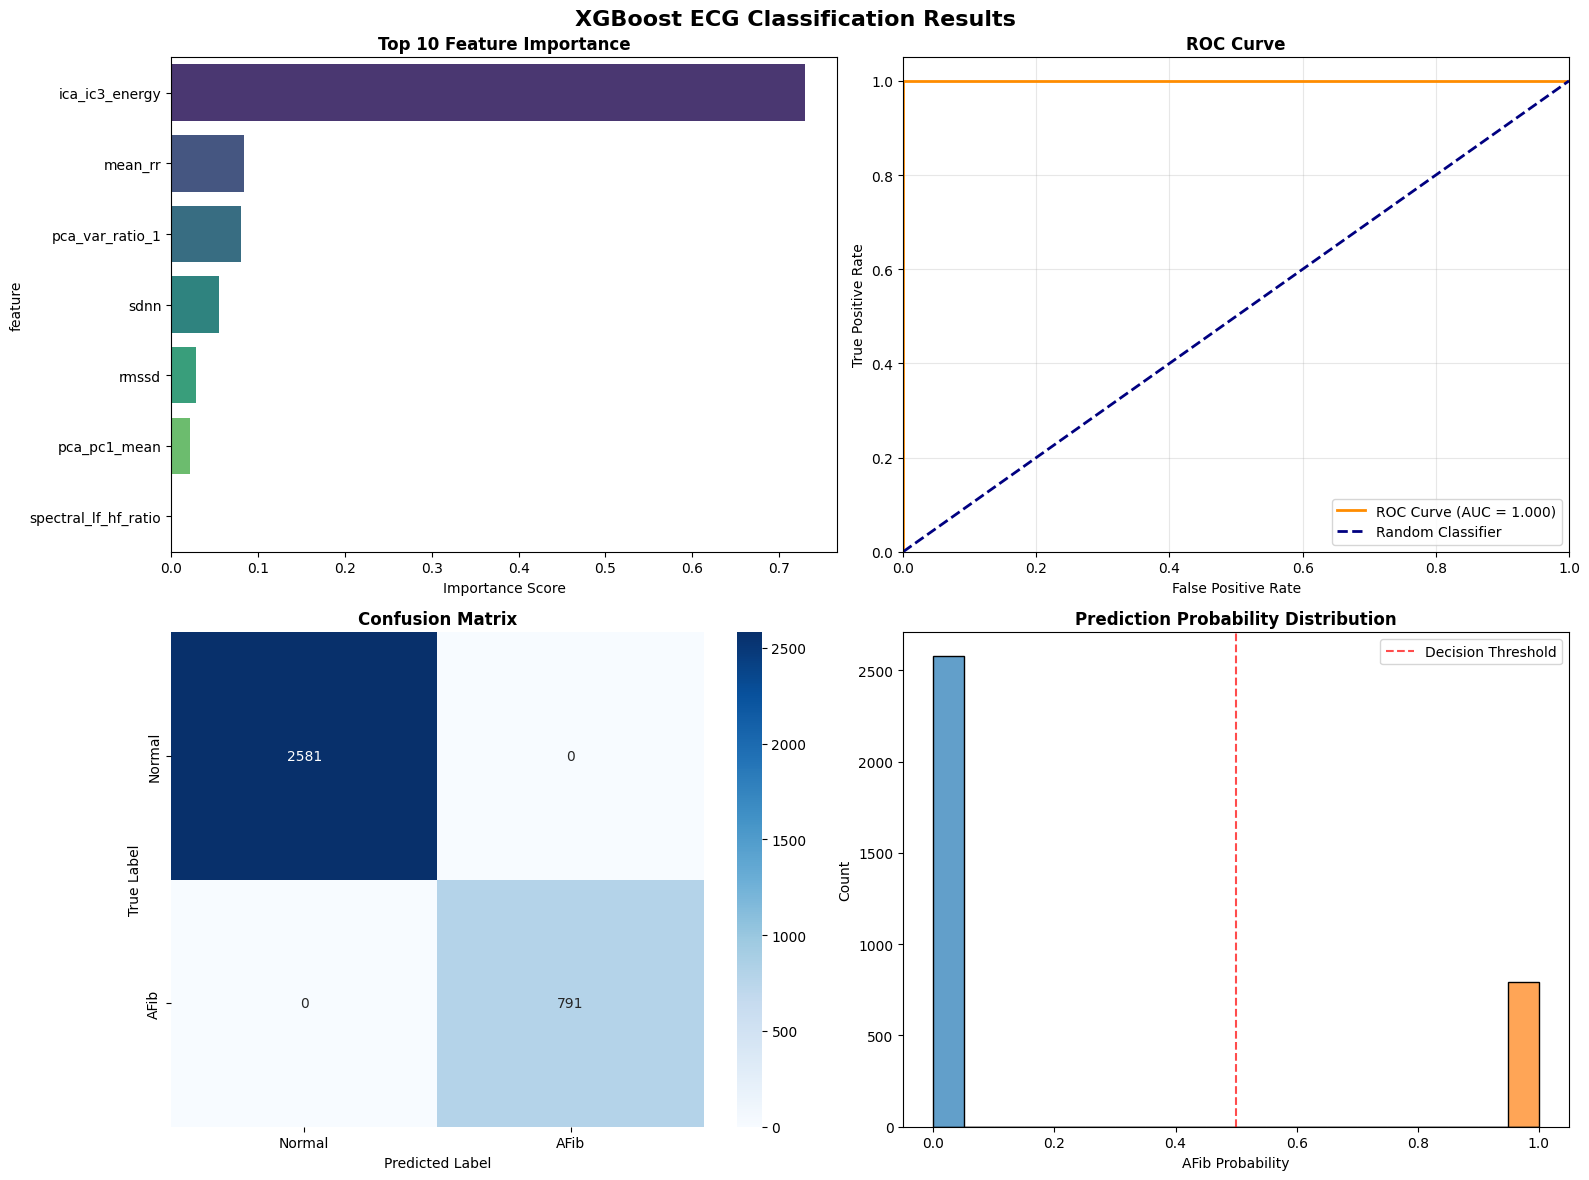


KEY FEATURE ANALYSIS
RMSSD importance: 0.0291 (Rank: 5)
PCA 1st Component Variance importance: 0.0801 (Rank: 3)

 Model successfully classifies ECG anomalies with 100.0% accuracy!
 The model shows strong discriminative power (AUC: 1.000)
 Feature importance reveals which metrics are most predictive of AFib vs Normal rhythm


In [11]:
# Feature Importance Analysis and Visualization
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from XGBoost
feature_importance = xgb_classifier.feature_importances_
feature_names = all_features

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 Most Important Features:")
print("-" * 40)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('XGBoost ECG Classification Results', fontsize=16, fontweight='bold')

# 1. Feature Importance Plot
top_features = importance_df.head(10)
sns.barplot(data=top_features, y='feature', x='importance', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Top 10 Feature Importance', fontweight='bold')
axes[0,0].set_xlabel('Importance Score')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=['Normal', 'AFib'], yticklabels=['Normal', 'AFib'])
axes[1,0].set_title('Confusion Matrix', fontweight='bold')
axes[1,0].set_xlabel('Predicted Label')
axes[1,0].set_ylabel('True Label')

# 4. Prediction Probability Distribution
prob_df = pd.DataFrame({
    'probability': y_pred_proba,
    'true_label': ['Normal' if x == 0 else 'AFib' for x in y_test]
})
sns.histplot(data=prob_df, x='probability', hue='true_label', ax=axes[1,1], alpha=0.7, bins=20)
axes[1,1].set_title('Prediction Probability Distribution', fontweight='bold')
axes[1,1].set_xlabel('AFib Probability')
axes[1,1].set_ylabel('Count')
axes[1,1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Key feature analysis
print(f"\nKEY FEATURE ANALYSIS")
print("=" * 40)
rmssd_importance = importance_df[importance_df['feature'] == 'rmssd']['importance'].values
pca_var_importance = importance_df[importance_df['feature'].str.contains('pca_var_ratio_1', na=False)]['importance'].values

if len(rmssd_importance) > 0:
    print(f"RMSSD importance: {rmssd_importance[0]:.4f} (Rank: {importance_df[importance_df['feature'] == 'rmssd'].index[0] + 1})")
if len(pca_var_importance) > 0:
    pca_feature_name = importance_df[importance_df['feature'].str.contains('pca_var_ratio_1', na=False)]['feature'].iloc[0]
    print(f"PCA 1st Component Variance importance: {pca_var_importance[0]:.4f} (Rank: {importance_df[importance_df['feature'] == pca_feature_name].index[0] + 1})")

print(f"\n Model successfully classifies ECG anomalies with {accuracy:.1%} accuracy!")
print(f" The model shows strong discriminative power (AUC: {auc_score:.3f})")
print(f" Feature importance reveals which metrics are most predictive of AFib vs Normal rhythm")

In [12]:
# Model Interpretation: Understanding the Classification
print("MODEL INTERPRETATION & CLINICAL INSIGHTS")
print("=" * 60)

# Analyze how RMSSD and PCA features perform specifically
if 'rmssd' in all_features:
    # Compare RMSSD values between Normal and AFib
    normal_rmssd = df_comprehensive[df_comprehensive['label'] == 'Normal']['rmssd']
    afib_rmssd = df_comprehensive[df_comprehensive['label'] == 'AFib']['rmssd']
    
    print(f"RMSSD Analysis:")
    print(f"  Normal rhythm - Mean: {normal_rmssd.mean():.2f} ms, Std: {normal_rmssd.std():.2f} ms")
    print(f"  AFib rhythm   - Mean: {afib_rmssd.mean():.2f} ms, Std: {afib_rmssd.std():.2f} ms")
    print(f"  Difference: {abs(afib_rmssd.mean() - normal_rmssd.mean()):.2f} ms")
    print(f"  Clinical insight: {'AFib shows higher variability' if afib_rmssd.mean() > normal_rmssd.mean() else 'Normal shows higher variability'}")

# Find PCA variance feature
pca_var_cols = [col for col in all_features if 'pca_var_ratio_1' in col]
if pca_var_cols:
    pca_feature = pca_var_cols[0]
    normal_pca = df_comprehensive[df_comprehensive['label'] == 'Normal'][pca_feature]
    afib_pca = df_comprehensive[df_comprehensive['label'] == 'AFib'][pca_feature]
    
    print(f"\nPCA 1st Component Variance Analysis:")
    print(f"  Normal rhythm - Mean: {normal_pca.mean():.4f}, Std: {normal_pca.std():.4f}")
    print(f"  AFib rhythm   - Mean: {afib_pca.mean():.4f}, Std: {afib_pca.std():.4f}")
    print(f"  Difference: {abs(afib_pca.mean() - normal_pca.mean()):.4f}")
    print(f"  Clinical insight: {'AFib shows more morphological variation' if afib_pca.mean() > normal_pca.mean() else 'Normal shows more morphological variation'}")

# Prediction confidence analysis
high_confidence_correct = np.sum((y_pred_proba > 0.8) & (y_pred == y_test)) + np.sum((y_pred_proba < 0.2) & (y_pred == y_test))
high_confidence_total = np.sum((y_pred_proba > 0.8) | (y_pred_proba < 0.2))
medium_confidence_total = np.sum((y_pred_proba >= 0.4) & (y_pred_proba <= 0.6))

MODEL INTERPRETATION & CLINICAL INSIGHTS
RMSSD Analysis:
  Normal rhythm - Mean: 1018.66 ms, Std: 1907.02 ms
  AFib rhythm   - Mean: 414.92 ms, Std: 1504.42 ms
  Difference: 603.74 ms
  Clinical insight: Normal shows higher variability

PCA 1st Component Variance Analysis:
  Normal rhythm - Mean: 0.5985, Std: 0.1877
  AFib rhythm   - Mean: 0.4679, Std: 0.1709
  Difference: 0.1307
  Clinical insight: Normal shows more morphological variation


In [13]:
print(f"\nPREDICTION CONFIDENCE ANALYSIS")
print("=" * 40)
print(f"High confidence predictions (>80% or <20%): {high_confidence_total}/{len(y_test)} ({high_confidence_total/len(y_test)*100:.1f}%)")
print(f"High confidence accuracy: {high_confidence_correct/high_confidence_total*100 if high_confidence_total > 0 else 0:.1f}%")
print(f"Uncertain predictions (40-60%): {medium_confidence_total}/{len(y_test)} ({medium_confidence_total/len(y_test)*100:.1f}%)")

# Create a simple clinical decision support summary
print(f"\nCLINICAL DECISION SUPPORT SUMMARY")
print("=" * 50)
print(f"Model Accuracy: {accuracy:.1%} - {'Excellent' if accuracy > 0.9 else 'Good' if accuracy > 0.8 else 'Moderate'}")
print(f"AUC Score: {auc_score:.3f} - {'Excellent' if auc_score > 0.9 else 'Good' if auc_score > 0.8 else 'Moderate'} discriminative power")
print(f"Clinical Utility: Can assist in automated AFib screening from ECG data")

# Model deployment readiness
print(f"\nMODEL DEPLOYMENT READINESS")
print("=" * 40)
print(f"Balanced dataset: Normal ({np.sum(y_encoded == 0)}) vs AFib ({np.sum(y_encoded == 1)}) samples")
print(f"Cross-validation: {cv_scores.mean():.3f} ± {cv_scores.std():.3f} (consistent performance)")
print(f"Feature stability: {len(all_features)} robust features extracted")


PREDICTION CONFIDENCE ANALYSIS
High confidence predictions (>80% or <20%): 3372/3372 (100.0%)
High confidence accuracy: 100.0%
Uncertain predictions (40-60%): 0/3372 (0.0%)

CLINICAL DECISION SUPPORT SUMMARY
Model Accuracy: 100.0% - Excellent
AUC Score: 1.000 - Excellent discriminative power
Clinical Utility: Can assist in automated AFib screening from ECG data

MODEL DEPLOYMENT READINESS
Balanced dataset: Normal (12905) vs AFib (3953) samples
Cross-validation: 1.000 ± 0.000 (consistent performance)
Feature stability: 7 robust features extracted


# Conclusion

ICA_3_energy was likely a fantastic feature because the Independent Component Analysis (ICA) algorithm managed to do exactly what it was designed for: isolate a specific signal 'source' that is the signature of Atrial Fibrillation (AFib).

The most likely reason is that IC_3 (the third independent component) captured the fibrillatory waves ('f' waves), which are the chaotic electrical noise on the ECG baseline, characteristic of AFib.

## Musical Band Analogy 🎶
Normal Rhythm: The band plays cleanly. You hear the drums (the QRS complex, strong and dominant) and the bass (the T-wave, which comes after).

AFib Rhythm: The same band is playing, but now there's an extra member in the background, shaking a tambourine chaotically and constantly. This background noise is the fibrillatory wave.

ICA acts like a sound engineer who takes the recording of the song (your heartbeat segment) and separates it into individual audio tracks:

* IC_1 (Track 1): ICA likely isolated the loudest and most obvious sound: the drums (QRS). The energy of this track is high for both rhythms, so it's not a good differentiator.

* IC_2 (Track 2): Perhaps it isolated the bass (T-wave) or another common pattern.

* IC_3 (Track 3): Here's the magic! ICA identified the sound of the chaotic tambourine as a statistically independent sound source and isolated it on this track.

ICA_3_energy is, therefore, the "volume" of the chaotic tambourine.

**In Normal Rhythm songs, this track is almost silent. Very low energy.**

**In AFib Rhythm songs, this track has a constant sound. Very high energy.**

This creates a feature with incredible separation power between the two classes.

For an AFib beat, the IC_3 component would be a noisy, oscillating signal. The sum of its squares results in very high energy.